# Análise Geográfica 

**Objetivo Estratégico:** Otimizar o alcance ao público-alvo e analisar possibilidades de expansões futuras.

**Foco:** Análises geográficas que gerem insights para decisões operacionais estratégicas.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 1. Carregamento e Preparação dos Dados
Carregamento da base limpa e criação de segmentações geográficas estratégicas.


In [3]:
df = pd.read_csv('../tratamento_inicial/Base_Kaiserhaus_Limpa.csv')

print("📊 DADOS CARREGADOS")
print("=" * 50)
print(f"Registros: {len(df):,}")
print(f"Período: {df['order_datetime'].min()} até {df['order_datetime'].max()}")
print(f"Clientes únicos: {df['nome_cliente'].nunique():,}")
print(f"Bairros atendidos: {df['bairro_destino'].nunique()}")
print(f"Macro regiões: {df['macro_bairro'].nunique()}")

# Converter para datetime
df['order_datetime'] = pd.to_datetime(df['order_datetime'])

# Estatísticas de distância
print(f"\n📍 ESTATÍSTICAS DE DISTÂNCIA:")
print(f"Distância mínima: {df['distance_km'].min():.2f} km")
print(f"Distância média: {df['distance_km'].mean():.2f} km")
print(f"Distância máxima: {df['distance_km'].max():.2f} km")
print(f"Distância mediana: {df['distance_km'].median():.2f} km")


📊 DADOS CARREGADOS
Registros: 5,000
Período: 2024-01-01 15:08:00 até 2024-12-31 21:27:00
Clientes únicos: 2,000
Bairros atendidos: 20
Macro regiões: 10

📍 ESTATÍSTICAS DE DISTÂNCIA:
Distância mínima: 0.00 km
Distância média: 3.51 km
Distância máxima: 9.95 km
Distância mediana: 3.66 km


## 2. Análise de Frequência de Pedidos por Cliente
Cálculo da frequência de pedidos para cada cliente e análise do comportamento.


In [4]:
# Calcular frequência de pedidos por cliente
frequencia_clientes = df.groupby('nome_cliente').agg({
    'order_datetime': 'count',  # número de pedidos
    'distance_km': 'mean',  # distância média dos pedidos
    'satisfacao_nivel': 'mean',  # satisfação média
    'total_brl': 'mean'  # valor médio do pedido
}).rename(columns={
    'order_datetime': 'frequencia_pedidos',
    'distance_km': 'distancia_media_km',
    'satisfacao_nivel': 'satisfacao_media',
    'total_brl': 'ticket_medio_brl'
}).round(2)

print("📈 ANÁLISE DE FREQUÊNCIA DE PEDIDOS POR CLIENTE")
print("=" * 60)
print(f"\nTotal de clientes únicos: {len(frequencia_clientes):,}")
print(f"\nDistribuição de frequência de pedidos:")
print(frequencia_clientes['frequencia_pedidos'].describe())

print(f"\n🔝 TOP 10 CLIENTES MAIS FREQUENTES:")
top_clientes = frequencia_clientes.nlargest(10, 'frequencia_pedidos')
print(top_clientes)

print(f"\n📊 SEGMENTAÇÃO POR FREQUÊNCIA:")
freq_dist = frequencia_clientes['frequencia_pedidos'].value_counts().sort_index()
print(f"Clientes com 1 pedido: {(frequencia_clientes['frequencia_pedidos'] == 1).sum()}")
print(f"Clientes com 2 pedidos: {(frequencia_clientes['frequencia_pedidos'] == 2).sum()}")
print(f"Clientes com 3+ pedidos: {(frequencia_clientes['frequencia_pedidos'] >= 3).sum()}")


📈 ANÁLISE DE FREQUÊNCIA DE PEDIDOS POR CLIENTE

Total de clientes únicos: 2,000

Distribuição de frequência de pedidos:
count    2000.000000
mean        2.500000
std         0.500125
min         2.000000
25%         2.000000
50%         2.500000
75%         3.000000
max         3.000000
Name: frequencia_pedidos, dtype: float64

🔝 TOP 10 CLIENTES MAIS FREQUENTES:
                frequencia_pedidos  distancia_media_km  satisfacao_media  \
nome_cliente                                                               
Ana A. Moreira                   3                3.56              4.33   
Ana Carvalho                     3                6.23              4.67   
Ana Correia                      3                2.79              4.67   
Ana D. Batista                   3                2.09              4.67   
Ana Duarte                       3                3.71              4.33   
Ana E. Araújo                    3                2.18              4.67   
Ana F. Gomes               

## 3. Correlação entre Distância e Frequência de Pedidos
**Objetivo:** Analisar se a distância impacta na frequência de pedidos dos clientes.


In [7]:
print("🔍 CORRELAÇÃO: DISTÂNCIA vs FREQUÊNCIA DE PEDIDOS")
print("=" * 60)

# Calcular correlação
correlacao_dist_freq = frequencia_clientes['distancia_media_km'].corr(frequencia_clientes['frequencia_pedidos'])
print(f"\n📌 Correlação entre distância e frequência: {correlacao_dist_freq:.4f}")

if correlacao_dist_freq < -0.3:
    print("   → Correlação NEGATIVA FORTE: Clientes mais distantes pedem menos")
elif correlacao_dist_freq < -0.1:
    print("   → Correlação NEGATIVA MODERADA: Distância reduz frequência de pedidos")
elif correlacao_dist_freq > 0.3:
    print("   → Correlação POSITIVA FORTE: Clientes mais distantes pedem mais")
elif correlacao_dist_freq > 0.1:
    print("   → Correlação POSITIVA MODERADA: Distância aumenta frequência")
else:
    print("   → Correlação FRACA: Distância não impacta significativamente a frequência")

# Análise por faixas de distância
def classificar_distancia(dist):
    if dist < 2:
        return 'Muito Próximo (0-2km)'
    elif dist < 4:
        return 'Próximo (2-4km)'
    elif dist < 6:
        return 'Médio (4-6km)'
    else:
        return 'Distante (6+km)'

frequencia_clientes['faixa_distancia'] = frequencia_clientes['distancia_media_km'].apply(classificar_distancia)

analise_faixas = frequencia_clientes.groupby('faixa_distancia').agg({
    'frequencia_pedidos': ['count', 'mean', 'median'],
    'satisfacao_media': 'mean',
    'ticket_medio_brl': 'mean'
}).round(2)

print(f"\n📊 ANÁLISE POR FAIXA DE DISTÂNCIA:")
print(analise_faixas)

# Identificar padrão
print(f"\n💡 INSIGHTS:")
faixa_maior_freq = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().idxmax()
maior_freq_media = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().max()
print(f"• Faixa com maior frequência média: {faixa_maior_freq} ({maior_freq_media:.1f} pedidos)")

faixa_menor_freq = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().idxmin()
menor_freq_media = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().min()
print(f"• Faixa com menor frequência média: {faixa_menor_freq} ({menor_freq_media:.1f} pedidos)")


🔍 CORRELAÇÃO: DISTÂNCIA vs FREQUÊNCIA DE PEDIDOS

📌 Correlação entre distância e frequência: 0.0254
   → Correlação FRACA: Distância não impacta significativamente a frequência

📊 ANÁLISE POR FAIXA DE DISTÂNCIA:
                      frequencia_pedidos              satisfacao_media  \
                                   count  mean median             mean   
faixa_distancia                                                          
Distante (6+km)                      136  2.42    2.0             4.62   
Muito Próximo (0-2km)                366  2.43    2.0             4.83   
Médio (4-6km)                        629  2.51    3.0             4.70   
Próximo (2-4km)                      869  2.53    3.0             4.74   

                      ticket_medio_brl  
                                  mean  
faixa_distancia                         
Distante (6+km)                 107.76  
Muito Próximo (0-2km)           111.28  
Médio (4-6km)                   110.43  
Próximo (2-4km)        

## 4. Correlação com Satisfação
**Objetivo:** Analisar como distância e frequência impactam a satisfação dos clientes.


In [8]:
print("⭐ ANÁLISE DE SATISFAÇÃO")
print("=" * 60)

# Correlações com satisfação
corr_dist_satisfacao = frequencia_clientes['distancia_media_km'].corr(frequencia_clientes['satisfacao_media'])
corr_freq_satisfacao = frequencia_clientes['frequencia_pedidos'].corr(frequencia_clientes['satisfacao_media'])

print(f"\n📌 CORRELAÇÕES COM SATISFAÇÃO:")
print(f"• Distância vs Satisfação: {corr_dist_satisfacao:.4f}")
print(f"• Frequência vs Satisfação: {corr_freq_satisfacao:.4f}")

# Interpretação da correlação distância-satisfação
print(f"\n🔍 INTERPRETAÇÃO - Distância vs Satisfação:")
if corr_dist_satisfacao < -0.3:
    print("   → Correlação NEGATIVA FORTE: Clientes distantes ficam menos satisfeitos")
elif corr_dist_satisfacao < -0.1:
    print("   → Correlação NEGATIVA MODERADA: Distância reduz satisfação")
elif corr_dist_satisfacao > 0.3:
    print("   → Correlação POSITIVA FORTE: Clientes distantes ficam mais satisfeitos")
elif corr_dist_satisfacao > 0.1:
    print("   → Correlação POSITIVA MODERADA: Distância aumenta satisfação")
else:
    print("   → Correlação FRACA: Distância não impacta significativamente a satisfação")

# Interpretação da correlação frequência-satisfação
print(f"\n🔍 INTERPRETAÇÃO - Frequência vs Satisfação:")
if corr_freq_satisfacao < -0.3:
    print("   → Correlação NEGATIVA FORTE: Clientes frequentes ficam menos satisfeitos")
elif corr_freq_satisfacao < -0.1:
    print("   → Correlação NEGATIVA MODERADA: Alta frequência reduz satisfação")
elif corr_freq_satisfacao > 0.3:
    print("   → Correlação POSITIVA FORTE: Clientes frequentes ficam mais satisfeitos")
elif corr_freq_satisfacao > 0.1:
    print("   → Correlação POSITIVA MODERADA: Frequência aumenta satisfação")
else:
    print("   → Correlação FRACA: Frequência não impacta significativamente a satisfação")

# Análise por faixa de distância e satisfação
print(f"\n📊 SATISFAÇÃO POR FAIXA DE DISTÂNCIA:")
satisfacao_por_faixa = frequencia_clientes.groupby('faixa_distancia')['satisfacao_media'].agg(['mean', 'std', 'count']).round(2)
print(satisfacao_por_faixa)

# Segmentação por frequência
def classificar_frequencia(freq):
    if freq == 1:
        return 'Ocasional (1 pedido)'
    elif freq == 2:
        return 'Regular (2 pedidos)'
    elif freq <= 4:
        return 'Frequente (3-4 pedidos)'
    else:
        return 'Muito Frequente (5+ pedidos)'

frequencia_clientes['segmento_frequencia'] = frequencia_clientes['frequencia_pedidos'].apply(classificar_frequencia)

print(f"\n📊 SATISFAÇÃO POR SEGMENTO DE FREQUÊNCIA:")
satisfacao_por_frequencia = frequencia_clientes.groupby('segmento_frequencia')['satisfacao_media'].agg(['mean', 'std', 'count']).round(2)
print(satisfacao_por_frequencia)


⭐ ANÁLISE DE SATISFAÇÃO

📌 CORRELAÇÕES COM SATISFAÇÃO:
• Distância vs Satisfação: -0.1596
• Frequência vs Satisfação: -0.0157

🔍 INTERPRETAÇÃO - Distância vs Satisfação:
   → Correlação NEGATIVA MODERADA: Distância reduz satisfação

🔍 INTERPRETAÇÃO - Frequência vs Satisfação:
   → Correlação FRACA: Frequência não impacta significativamente a satisfação

📊 SATISFAÇÃO POR FAIXA DE DISTÂNCIA:
                       mean   std  count
faixa_distancia                         
Distante (6+km)        4.62  0.40    136
Muito Próximo (0-2km)  4.83  0.28    366
Médio (4-6km)          4.70  0.35    629
Próximo (2-4km)        4.74  0.37    869

📊 SATISFAÇÃO POR SEGMENTO DE FREQUÊNCIA:
                         mean   std  count
segmento_frequencia                       
Frequente (3-4 pedidos)  4.73  0.33   1000
Regular (2 pedidos)      4.74  0.38   1000


## 5. Análise Geográfica por Região
**Objetivo:** Analisar padrões geográficos por macro bairro e bairro de endereço do pedido.


In [9]:
print("🗺️ ANÁLISE GEOGRÁFICA POR REGIÃO")
print("=" * 60)

# Análise por macro bairro
analise_macro = df.groupby('macro_bairro').agg({
    'order_datetime': 'count',
    'distance_km': 'mean',
    'satisfacao_nivel': 'mean',
    'total_brl': 'mean',
    'nome_cliente': 'nunique'
}).rename(columns={
    'order_datetime': 'total_pedidos',
    'distance_km': 'distancia_media',
    'satisfacao_nivel': 'satisfacao_media',
    'total_brl': 'ticket_medio',
    'nome_cliente': 'clientes_unicos'
}).sort_values('total_pedidos', ascending=False).round(2)

print(f"\n📍 ANÁLISE POR MACRO BAIRRO:")
print(analise_macro)

print(f"\n🏆 TOP 5 REGIÕES:")
print(f"• Maior volume: {analise_macro['total_pedidos'].idxmax()} ({analise_macro['total_pedidos'].max()} pedidos)")
print(f"• Maior satisfação: {analise_macro['satisfacao_media'].idxmax()} ({analise_macro['satisfacao_media'].max():.2f})")
print(f"• Maior ticket médio: {analise_macro['ticket_medio'].idxmax()} (R$ {analise_macro['ticket_medio'].max():.2f})")

# Top 10 bairros
analise_bairros = df.groupby('bairro_destino').agg({
    'order_datetime': 'count',
    'distance_km': 'mean',
    'satisfacao_nivel': 'mean'
}).rename(columns={
    'order_datetime': 'pedidos',
    'distance_km': 'dist_media',
    'satisfacao_nivel': 'satisfacao'
}).sort_values('pedidos', ascending=False).round(2)

print(f"\n📊 TOP 10 BAIRROS MAIS ATENDIDOS:")
print(analise_bairros.head(10))


🗺️ ANÁLISE GEOGRÁFICA POR REGIÃO

📍 ANÁLISE POR MACRO BAIRRO:
              total_pedidos  distancia_media  satisfacao_media  ticket_medio  \
macro_bairro                                                                   
Brooklin                881             0.87              4.83        110.48   
Moema                   679             2.59              4.79        107.36   
Vila Mariana            530             4.19              4.74        111.35   
Vila Olímpia            516             2.70              4.77        108.70   
Itaim                   497             3.28              4.72        111.44   
Jardins                 403             4.55              4.67        114.38   
Pinheiros               393             4.79              4.70        108.24   
Santo Amaro             387             4.69              4.70        112.28   
Outros                  364             5.65              4.69        109.82   
Morumbi                 350             6.29              

## 6. Visualizações Estratégicas
**Objetivo:** Gráficos para insights visuais de expansão geográfica.


📊 VISUALIZAÇÕES ESTRATÉGICAS


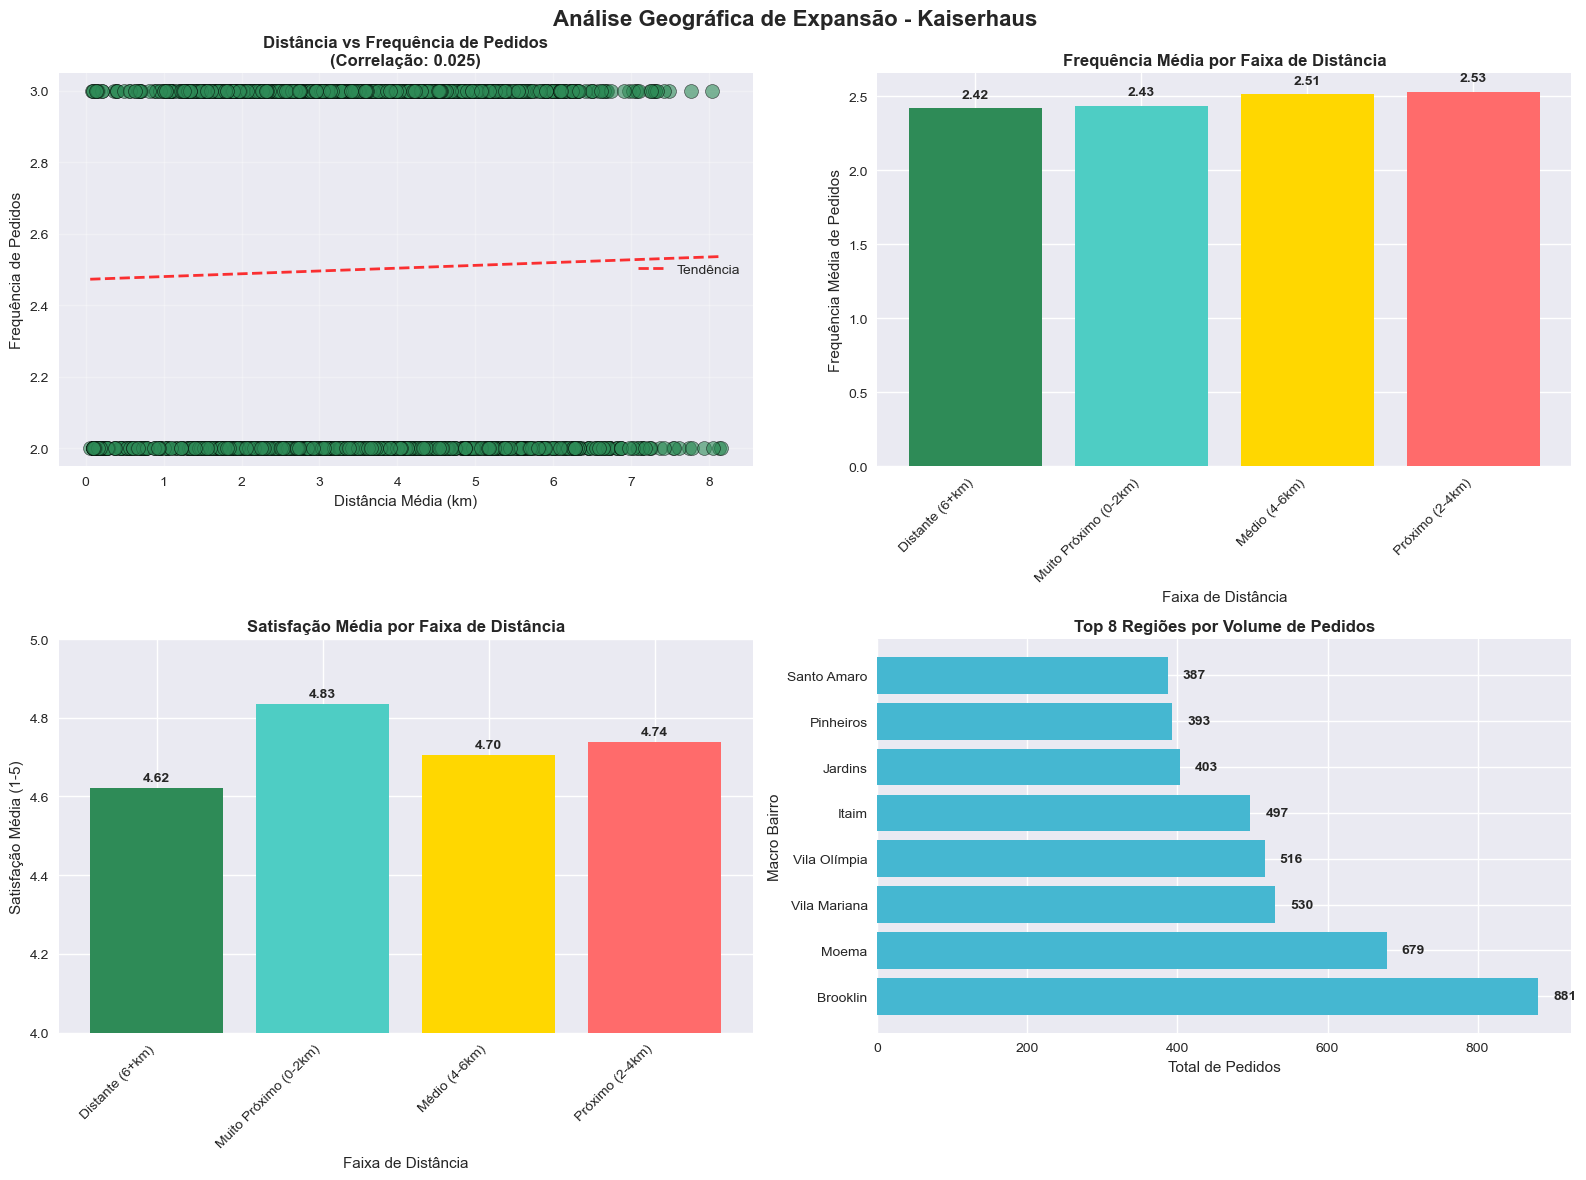

In [10]:
print("📊 VISUALIZAÇÕES ESTRATÉGICAS")
print("=" * 50)

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise Geográfica de Expansão - Kaiserhaus', fontsize=16, fontweight='bold')

# Gráfico 1: Scatter - Distância vs Frequência
ax1 = axes[0, 0]
scatter1 = ax1.scatter(frequencia_clientes['distancia_media_km'], 
                       frequencia_clientes['frequencia_pedidos'],
                       alpha=0.6, s=100, c='#2E8B57', edgecolors='black', linewidth=0.5)
ax1.set_title(f'Distância vs Frequência de Pedidos\n(Correlação: {correlacao_dist_freq:.3f})', 
              fontweight='bold')
ax1.set_xlabel('Distância Média (km)')
ax1.set_ylabel('Frequência de Pedidos')
ax1.grid(True, alpha=0.3)

# Adicionar linha de tendência
z1 = np.polyfit(frequencia_clientes['distancia_media_km'], 
                frequencia_clientes['frequencia_pedidos'], 1)
p1 = np.poly1d(z1)
x_line = np.linspace(frequencia_clientes['distancia_media_km'].min(), 
                     frequencia_clientes['distancia_media_km'].max(), 100)
ax1.plot(x_line, p1(x_line), "r--", alpha=0.8, linewidth=2, label='Tendência')
ax1.legend()

# Gráfico 2: Frequência por Faixa de Distância
ax2 = axes[0, 1]
freq_por_faixa = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().sort_index()
colors_faixa = ['#2E8B57', '#4ECDC4', '#FFD700', '#FF6B6B']
bars2 = ax2.bar(range(len(freq_por_faixa)), freq_por_faixa.values, color=colors_faixa)
ax2.set_title('Frequência Média por Faixa de Distância', fontweight='bold')
ax2.set_ylabel('Frequência Média de Pedidos')
ax2.set_xlabel('Faixa de Distância')
ax2.set_xticks(range(len(freq_por_faixa)))
ax2.set_xticklabels(freq_por_faixa.index, rotation=45, ha='right')

# Adicionar valores nas barras
for i, v in enumerate(freq_por_faixa.values):
    ax2.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 3: Satisfação por Faixa de Distância
ax3 = axes[1, 0]
sat_por_faixa = frequencia_clientes.groupby('faixa_distancia')['satisfacao_media'].mean().sort_index()
bars3 = ax3.bar(range(len(sat_por_faixa)), sat_por_faixa.values, color=colors_faixa)
ax3.set_title('Satisfação Média por Faixa de Distância', fontweight='bold')
ax3.set_ylabel('Satisfação Média (1-5)')
ax3.set_xlabel('Faixa de Distância')
ax3.set_xticks(range(len(sat_por_faixa)))
ax3.set_xticklabels(sat_por_faixa.index, rotation=45, ha='right')
ax3.set_ylim(4.0, 5.0)

# Adicionar valores nas barras
for i, v in enumerate(sat_por_faixa.values):
    ax3.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 4: Distribuição de Pedidos por Macro Bairro
ax4 = axes[1, 1]
top_macro = analise_macro.nlargest(8, 'total_pedidos')['total_pedidos']
bars4 = ax4.barh(range(len(top_macro)), top_macro.values, color='#45B7D1')
ax4.set_title('Top 8 Regiões por Volume de Pedidos', fontweight='bold')
ax4.set_xlabel('Total de Pedidos')
ax4.set_ylabel('Macro Bairro')
ax4.set_yticks(range(len(top_macro)))
ax4.set_yticklabels(top_macro.index)

# Adicionar valores nas barras
for i, v in enumerate(top_macro.values):
    ax4.text(v + 20, i, f'{int(v)}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


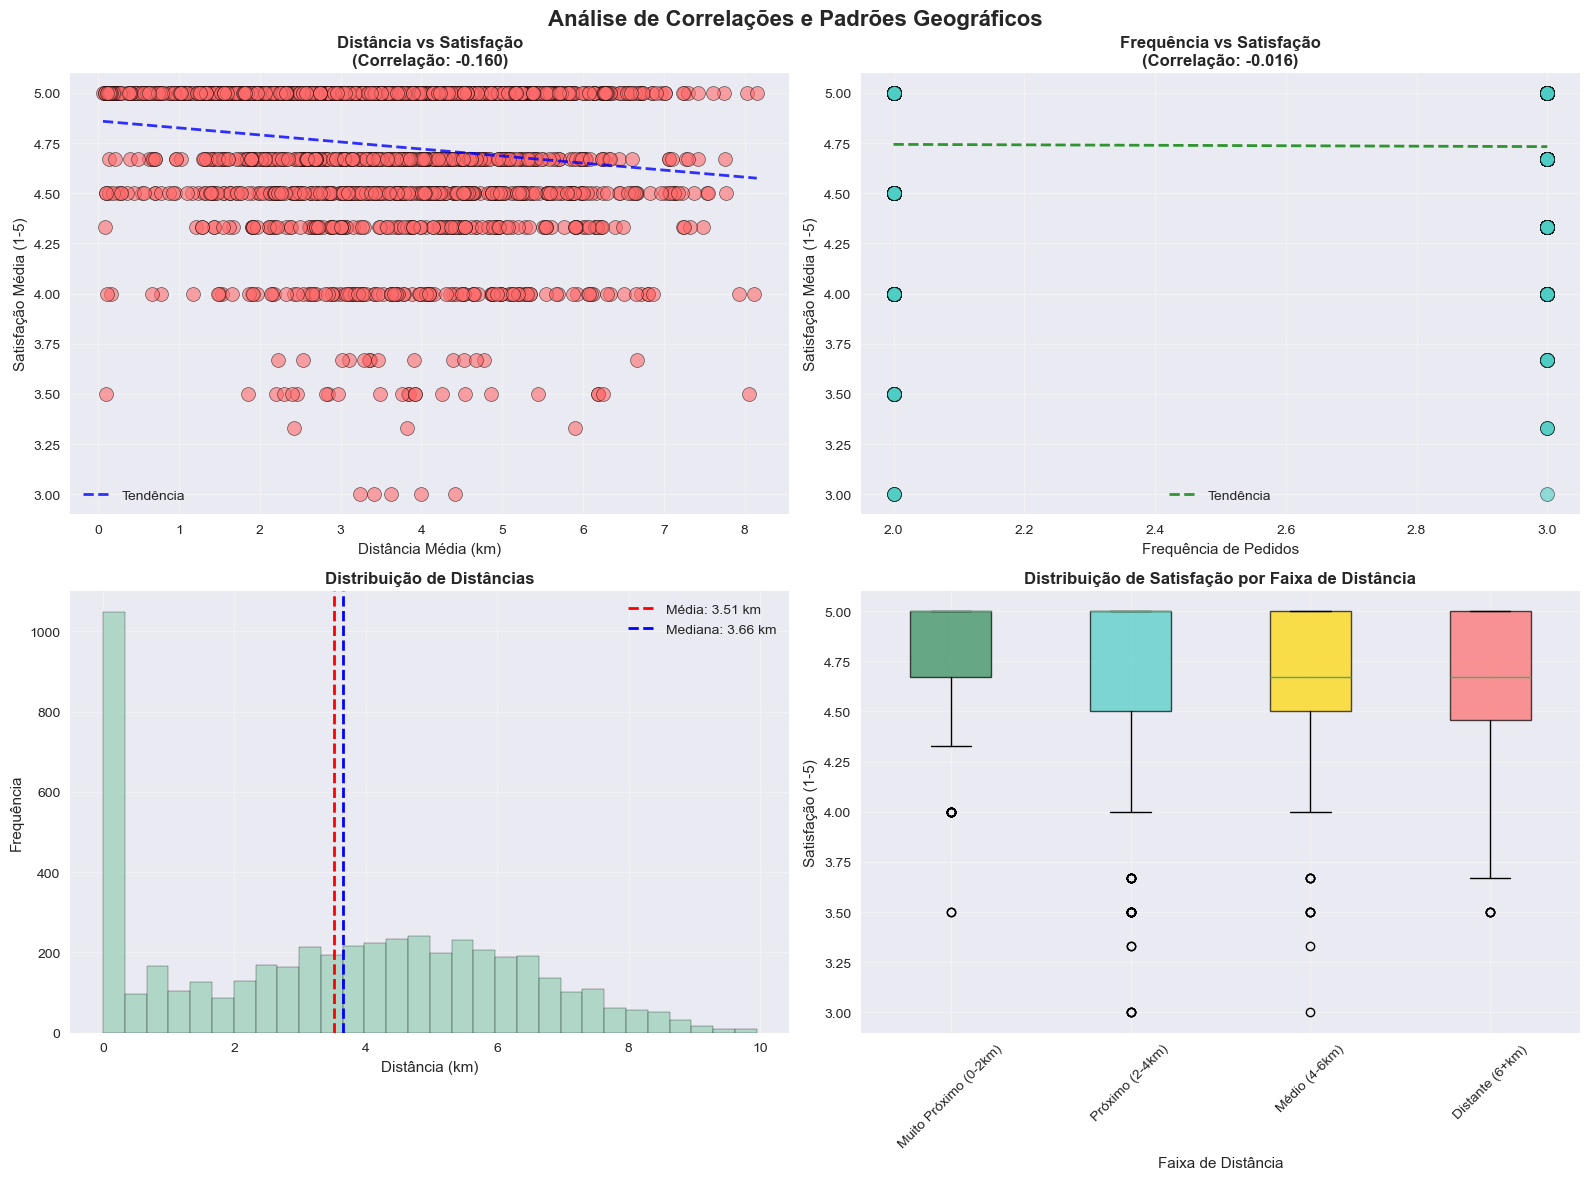

In [11]:
# Segunda bateria de gráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise de Correlações e Padrões Geográficos', fontsize=16, fontweight='bold')

# Gráfico 1: Scatter - Distância vs Satisfação
ax1 = axes[0, 0]
scatter2 = ax1.scatter(frequencia_clientes['distancia_media_km'], 
                       frequencia_clientes['satisfacao_media'],
                       alpha=0.6, s=100, c='#FF6B6B', edgecolors='black', linewidth=0.5)
ax1.set_title(f'Distância vs Satisfação\n(Correlação: {corr_dist_satisfacao:.3f})', 
              fontweight='bold')
ax1.set_xlabel('Distância Média (km)')
ax1.set_ylabel('Satisfação Média (1-5)')
ax1.grid(True, alpha=0.3)

# Adicionar linha de tendência
z2 = np.polyfit(frequencia_clientes['distancia_media_km'], 
                frequencia_clientes['satisfacao_media'], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(frequencia_clientes['distancia_media_km'].min(), 
                      frequencia_clientes['distancia_media_km'].max(), 100)
ax1.plot(x_line2, p2(x_line2), "b--", alpha=0.8, linewidth=2, label='Tendência')
ax1.legend()

# Gráfico 2: Scatter - Frequência vs Satisfação
ax2 = axes[0, 1]
scatter3 = ax2.scatter(frequencia_clientes['frequencia_pedidos'], 
                       frequencia_clientes['satisfacao_media'],
                       alpha=0.6, s=100, c='#4ECDC4', edgecolors='black', linewidth=0.5)
ax2.set_title(f'Frequência vs Satisfação\n(Correlação: {corr_freq_satisfacao:.3f})', 
              fontweight='bold')
ax2.set_xlabel('Frequência de Pedidos')
ax2.set_ylabel('Satisfação Média (1-5)')
ax2.grid(True, alpha=0.3)

# Adicionar linha de tendência
z3 = np.polyfit(frequencia_clientes['frequencia_pedidos'], 
                frequencia_clientes['satisfacao_media'], 1)
p3 = np.poly1d(z3)
x_line3 = np.linspace(frequencia_clientes['frequencia_pedidos'].min(), 
                      frequencia_clientes['frequencia_pedidos'].max(), 100)
ax2.plot(x_line3, p3(x_line3), "g--", alpha=0.8, linewidth=2, label='Tendência')
ax2.legend()

# Gráfico 3: Distribuição de Distâncias
ax3 = axes[1, 0]
ax3.hist(df['distance_km'], bins=30, color='#96CEB4', alpha=0.7, edgecolor='black')
ax3.axvline(df['distance_km'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Média: {df["distance_km"].mean():.2f} km')
ax3.axvline(df['distance_km'].median(), color='blue', linestyle='--', linewidth=2,
            label=f'Mediana: {df["distance_km"].median():.2f} km')
ax3.set_title('Distribuição de Distâncias', fontweight='bold')
ax3.set_xlabel('Distância (km)')
ax3.set_ylabel('Frequência')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Boxplot de Satisfação por Faixa de Distância
ax4 = axes[1, 1]
# Criar dados para boxplot
faixas_ordenadas = ['Muito Próximo (0-2km)', 'Próximo (2-4km)', 'Médio (4-6km)', 'Distante (6+km)']
dados_boxplot = [frequencia_clientes[frequencia_clientes['faixa_distancia'] == faixa]['satisfacao_media'].values 
                 for faixa in faixas_ordenadas]
bp = ax4.boxplot(dados_boxplot, labels=faixas_ordenadas, patch_artist=True)

# Colorir os boxes
for patch, color in zip(bp['boxes'], colors_faixa):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax4.set_title('Distribuição de Satisfação por Faixa de Distância', fontweight='bold')
ax4.set_ylabel('Satisfação (1-5)')
ax4.set_xlabel('Faixa de Distância')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Insights e Recomendações para Expansão
**Objetivo:** Consolidar insights estratégicos para decisões de expansão geográfica.


In [12]:
print("💡 INSIGHTS E RECOMENDAÇÕES ESTRATÉGICAS")
print("=" * 70)

print("\n🎯 PRINCIPAIS DESCOBERTAS:\n")

# Insight 1: Correlação Distância-Frequência
print("1. IMPACTO DA DISTÂNCIA NA FREQUÊNCIA DE PEDIDOS:")
print(f"   • Correlação: {correlacao_dist_freq:.4f}")
if abs(correlacao_dist_freq) > 0.3:
    direcao = "negativa" if correlacao_dist_freq < 0 else "positiva"
    print(f"   • ⚠️  Correlação {direcao} FORTE detectada!")
    if correlacao_dist_freq < 0:
        print(f"   • Clientes mais distantes tendem a fazer MENOS pedidos")
    else:
        print(f"   • Clientes mais distantes tendem a fazer MAIS pedidos")
else:
    print(f"   • ✅ Distância NÃO é barreira significativa para frequência")

# Insight 2: Correlação Distância-Satisfação
print(f"\n2. IMPACTO DA DISTÂNCIA NA SATISFAÇÃO:")
print(f"   • Correlação: {corr_dist_satisfacao:.4f}")
if abs(corr_dist_satisfacao) > 0.3:
    direcao = "negativa" if corr_dist_satisfacao < 0 else "positiva"
    print(f"   • ⚠️  Correlação {direcao} FORTE detectada!")
    if corr_dist_satisfacao < 0:
        print(f"   • Clientes distantes ficam MENOS satisfeitos")
        print(f"   • 🚨 ATENÇÃO: Possível problema de logística/entrega")
    else:
        print(f"   • Clientes distantes ficam MAIS satisfeitos")
else:
    print(f"   • ✅ Qualidade do serviço mantida em todas as distâncias")

# Insight 3: Faixas de distância mais rentáveis
print(f"\n3. ANÁLISE DE FAIXAS DE DISTÂNCIA:")
faixa_melhor_freq = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().idxmax()
faixa_melhor_sat = frequencia_clientes.groupby('faixa_distancia')['satisfacao_media'].mean().idxmax()
print(f"   • Melhor frequência: {faixa_melhor_freq}")
print(f"   • Melhor satisfação: {faixa_melhor_sat}")

# Insight 4: Regiões estratégicas
print(f"\n4. REGIÕES PRIORITÁRIAS PARA EXPANSÃO:")
top_3_regioes = analise_macro.nlargest(3, 'total_pedidos')
for i, (regiao, dados) in enumerate(top_3_regioes.iterrows(), 1):
    print(f"   {i}. {regiao}:")
    print(f"      • Pedidos: {dados['total_pedidos']}")
    print(f"      • Distância média: {dados['distancia_media']:.2f} km")
    print(f"      • Satisfação: {dados['satisfacao_media']:.2f}")

# Insight 5: Oportunidades de expansão
print(f"\n5. OPORTUNIDADES DE EXPANSÃO:")
# Regiões com alta satisfação mas baixo volume
regioes_potencial = analise_macro[
    (analise_macro['satisfacao_media'] > analise_macro['satisfacao_media'].median()) &
    (analise_macro['total_pedidos'] < analise_macro['total_pedidos'].median())
].sort_values('satisfacao_media', ascending=False)

if len(regioes_potencial) > 0:
    print(f"   • Regiões com alta satisfação mas baixo volume (potencial crescimento):")
    for regiao, dados in regioes_potencial.head(3).iterrows():
        print(f"      - {regiao}: Satisfação {dados['satisfacao_media']:.2f}, {dados['total_pedidos']} pedidos")
else:
    print(f"   • Todas as regiões de alta satisfação já têm alto volume")

# Recomendações finais
print(f"\n📋 RECOMENDAÇÕES ESTRATÉGICAS:\n")

if correlacao_dist_freq < -0.2:
    print("   1. ⚠️  Considerar abrir FILIAIS para reduzir distância média")
    print("      → Clientes distantes pedem menos frequentemente")
elif correlacao_dist_freq > 0.2:
    print("   1. ✅ Expandir alcance geográfico")
    print("      → Clientes distantes são igualmente ou mais engajados")
else:
    print("   1. ✅ Distância não é fator limitante significativo")

if corr_dist_satisfacao < -0.2:
    print("\n   2. 🚨 PRIORIDADE: Melhorar logística de entrega para longas distâncias")
    print("      → Satisfação cai com a distância")
else:
    print("\n   2. ✅ Qualidade de serviço consistente em todas as distâncias")

print(f"\n   3. 🎯 Focar em regiões de alta performance:")
for regiao in top_3_regioes.head(3).index:
    print(f"      • {regiao}")

print(f"\n   4. 💰 Explorar regiões sub-atendidas com alto potencial:")
if len(regioes_potencial) > 0:
    for regiao in regioes_potencial.head(3).index:
        print(f"      • {regiao}")
else:
    print(f"      • Todas as regiões principais já estão bem atendidas")

print("\n" + "=" * 70)


💡 INSIGHTS E RECOMENDAÇÕES ESTRATÉGICAS

🎯 PRINCIPAIS DESCOBERTAS:

1. IMPACTO DA DISTÂNCIA NA FREQUÊNCIA DE PEDIDOS:
   • Correlação: 0.0254
   • ✅ Distância NÃO é barreira significativa para frequência

2. IMPACTO DA DISTÂNCIA NA SATISFAÇÃO:
   • Correlação: -0.1596
   • ✅ Qualidade do serviço mantida em todas as distâncias

3. ANÁLISE DE FAIXAS DE DISTÂNCIA:
   • Melhor frequência: Próximo (2-4km)
   • Melhor satisfação: Muito Próximo (0-2km)

4. REGIÕES PRIORITÁRIAS PARA EXPANSÃO:
   1. Brooklin:
      • Pedidos: 881.0
      • Distância média: 0.87 km
      • Satisfação: 4.83
   2. Moema:
      • Pedidos: 679.0
      • Distância média: 2.59 km
      • Satisfação: 4.79
   3. Vila Mariana:
      • Pedidos: 530.0
      • Distância média: 4.19 km
      • Satisfação: 4.74

5. OPORTUNIDADES DE EXPANSÃO:
   • Todas as regiões de alta satisfação já têm alto volume

📋 RECOMENDAÇÕES ESTRATÉGICAS:

   1. ✅ Distância não é fator limitante significativo

   2. ✅ Qualidade de serviço consistente